# What data do we want to pull from the census API?

In this notebook we explore a number of GIS related issues:

1. Pulling remote data from census.gov
1. Using the census.gov API to retrieve particular demographic information at a state, county, track, block, blockgroup level.
1. Merge geographic data using GeoPandas
1. Plotting the results using folium

In [37]:
from census import Census
import matplotlib.pyplot as plt
import numpy as np
import folium

In [2]:
%matplotlib inline

In [4]:
import urllib.request
from zipfile import ZipFile
import pycurl
import geopandas as gpd
from io import BytesIO
from us import states
import os


In [5]:
import importlib
import us
from us import states
type(states)

module

## Asssume census key is stored

$HOME/.census/key.txt

In [6]:
with open(os.path.join(os.path.expanduser("~"),".census","key.txt")) as f:
    key = f.read().strip()

In [7]:
c = Census(key)
c.acs5.get(('NAME', 'B19001H_007E'),
          {'for': 'state:{}'.format(states.UT.fips)})

[{'NAME': 'Utah', 'B19001H_007E': 32805.0, 'state': '49'}]

In [8]:
c.sf1.state_county_tract('NAME', states.UT.fips, '17', Census.ALL)

[{'NAME': 'Census Tract 3', 'state': '49', 'county': '017', 'tract': '000300'},
 {'NAME': 'Census Tract 4', 'state': '49', 'county': '017', 'tract': '000400'}]

In [9]:
c.acs5.state('NAME', '49')

[{'NAME': 'Utah', 'state': '49'}]

# Here we're working with the UT shapefiles

In [10]:
#!pip install PyShp 
import shapefile
from zipfile import ZipFile
from io import StringIO
from urllib.request import urlopen
import matplotlib.pyplot as plt

### Use [tempfile](https://docs.python.org/3/library/tempfile.html)
* Keeps from cluttering user's directory

In [17]:

# save tract url as zip
import tempfile
#with tempfile.TemporaryFile() as f
#with open('block.zip', 'wb') as f:
def get_shape_files(geography="county"):
    with tempfile.NamedTemporaryFile(suffix=".zip", mode="wb", delete = False) as fp:
        c = pycurl.Curl()
        c.setopt(c.URL, states.UT.shapefile_urls()[geography])
        c.setopt(c.WRITEDATA, fp)
        c.perform()
        c.close()
    print(fp.name)
    print(os.path.exists(fp.name))

    data = gpd.read_file(f"zip://{fp.name}")
    os.remove(fp.name)
    return data

In [18]:
#utah_block = get_shape_files("block")
utah_blockgroup = get_shape_files("blockgroup")

/tmp/tmp0j0ij1cu.zip
True


In [19]:
utah_blockgroup.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [20]:
slc_blockgroup = utah_blockgroup[utah_blockgroup["COUNTYFP10"]=="035"]

In [22]:
c = Census(key, 2010)
sl_county_var = c.acs5.get(('NAME', 'B19013_001E'),
          {'for': "block group:*", 'in': "state:49 county:35"})
slc_income = gpd.GeoDataFrame.from_dict(sl_county_var)
slc_income.head()

B19013_001E                                               NAME block group  \
0      27625.0  Block Group 1, Census Tract 1001, Salt Lake Co...           1   
1      43646.0  Block Group 2, Census Tract 1001, Salt Lake Co...           2   
2     103170.0  Block Group 1, Census Tract 1002, Salt Lake Co...           1   
3      35775.0  Block Group 1, Census Tract 1003.06, Salt Lake...           1   
4      38281.0  Block Group 2, Census Tract 1003.06, Salt Lake...           2   

  county state   tract  
0    035    49  100100  
1    035    49  100100  
2    035    49  100200  
3    035    49  100306  
4    035    49  100306

In [64]:
slc_income["tract_bg"] = \
    slc_income.apply(lambda row: (row["tract"],
                                          row["block group"]),
                     axis=1)
slc_income.head()

B19013_001E                                               NAME block group  \
0      27625.0  Block Group 1, Census Tract 1001, Salt Lake Co...           1   
1      43646.0  Block Group 2, Census Tract 1001, Salt Lake Co...           2   
2     103170.0  Block Group 1, Census Tract 1002, Salt Lake Co...           1   
3      35775.0  Block Group 1, Census Tract 1003.06, Salt Lake...           1   
4      38281.0  Block Group 2, Census Tract 1003.06, Salt Lake...           2   

  county state   tract     tract_bg  
0    035    49  100100  (100100, 1)  
1    035    49  100100  (100100, 2)  
2    035    49  100200  (100200, 1)  
3    035    49  100306  (100306, 1)  
4    035    49  100306  (100306, 2)

In [65]:
slc_blockgroup.head(2)

STATEFP10 COUNTYFP10 TRACTCE10 BLKGRPCE10       GEOID10     NAMELSAD10  \
55        49        035    111802          2  490351118022  Block Group 2   
56        49        035    110900          2  490351109002  Block Group 2   

   MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10  \
55   G5030          S   729985         0  +40.7026578  -111.8585194   
56   G5030          S   968849         0  +40.6697512  -111.8128025   

                                             geometry     tract_bg  
55  POLYGON ((-111.865455 40.699886, -111.865458 4...  (111802, 2)  
56  POLYGON ((-111.806536 40.674937, -111.80648 40...  (110900, 2)

In [66]:
slc_blockgroup["tract_bg"] = \
    slc_blockgroup.apply(lambda row: (row["TRACTCE10"],
                                  row["BLKGRPCE10"]),
                     axis=1)
slc_blockgroup.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


STATEFP10 COUNTYFP10 TRACTCE10 BLKGRPCE10       GEOID10     NAMELSAD10  \
55        49        035    111802          2  490351118022  Block Group 2   
56        49        035    110900          2  490351109002  Block Group 2   
57        49        035    113522          2  490351135222  Block Group 2   
58        49        035    113514          1  490351135141  Block Group 1   
59        49        035    113523          3  490351135233  Block Group 3   

   MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10  \
55   G5030          S   729985         0  +40.7026578  -111.8585194   
56   G5030          S   968849         0  +40.6697512  -111.8128025   
57   G5030          S  1297374         0  +40.6603473  -111.9626660   
58   G5030          S   604541         0  +40.6666599  -111.9311412   
59   G5030          S   749974         0  +40.6426932  -111.9816886   

                                             geometry     tract_bg  
55  POLYGON ((-111.865455 40.699886, -111.865458 4...  (111802, 2)  
56  POLYGON ((-111.806536 40.674937, -111.80648 40...  (110900, 2)  
57  POLYGON ((-111.967442 40.66385, -111.967442 40...  (113522, 2)  
58  POLYGON ((-111.927894 40.67017, -111.927592 40...  (113514, 1)  
59  POLYGON ((-111.98275 40.638571, -111.982793 40...  (113523, 3)

In [67]:
slc_blockgroup.shape, slc_income.shape

((612, 14), (612, 7))

In [68]:
slc_census_income = slc_blockgroup.merge(slc_income, how='inner', 
                    on="tract_bg"
                   )
slc_census_income.crs = {'init' :'epsg:4326'}
slc_census_income.head(3)

STATEFP10 COUNTYFP10 TRACTCE10 BLKGRPCE10       GEOID10     NAMELSAD10  \
0        49        035    111802          2  490351118022  Block Group 2   
1        49        035    110900          2  490351109002  Block Group 2   
2        49        035    113522          2  490351135222  Block Group 2   

  MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10  \
0   G5030          S   729985         0  +40.7026578  -111.8585194   
1   G5030          S   968849         0  +40.6697512  -111.8128025   
2   G5030          S  1297374         0  +40.6603473  -111.9626660   

                                            geometry     tract_bg  \
0  POLYGON ((-111.865455 40.699886, -111.865458 4...  (111802, 2)   
1  POLYGON ((-111.806536 40.674937, -111.80648 40...  (110900, 2)   
2  POLYGON ((-111.967442 40.66385, -111.967442 40...  (113522, 2)   

   B19013_001E                                               NAME block group  \
0      53370.0  Block Group 2, Census Tract 1118.02, Salt Lake...           2   
1      85250.0  Block Group 2, Census Tract 1109, Salt Lake Co...           2   
2      78884.0  Block Group 2, Census Tract 1135.22, Salt Lake...           2   

  county state   tract  
0    035    49  111802  
1    035    49  110900  
2    035    49  113522

In [69]:
np.mean(slc_census_income["B19013_001E"])

63142.219672131148

In [70]:
slc_census_income["INTPTLAT10"] = \
    slc_census_income["INTPTLAT10"].apply(lambda x:float(x))
slc_census_income["INTPTLON10"] = \
    slc_census_income["INTPTLON10"].apply(lambda x:float(x))

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5,1,'Plotting median income by blockgroup for SL County')

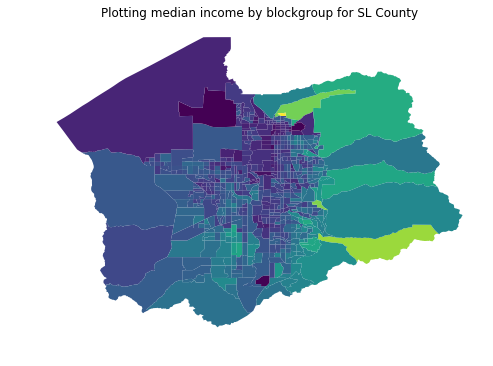

In [79]:
fig0, ax0 = plt.subplots()
fig0.set_size_inches(8,8)
slc_census_income.plot(column="B19013_001E", ax=ax0)
ax0.set_aspect("equal")
ax0.axis("off")
ax0.set_title("Plotting median income by blockgroup for SL County")


In [72]:
slc_census_income[['tract_bg','B19013_001E']]

tract_bg  B19013_001E
0    (111802, 2)      53370.0
1    (110900, 2)      85250.0
2    (113522, 2)      78884.0
3    (113514, 1)      46303.0
4    (113523, 3)      55263.0
5    (111202, 1)      48409.0
6    (112914, 3)      50400.0
7    (110401, 2)      23750.0
8    (104400, 1)     121354.0
9    (104800, 1)      64926.0
10   (110300, 1)      83068.0
11   (112609, 1)     112772.0
12   (111702, 1)      38611.0
13   (111101, 4)      69706.0
14   (112804, 4)      71557.0
15   (113537, 1)      58698.0
16   (112502, 3)      39277.0
17   (112612, 1)      78203.0
18   (110200, 2)      76375.0
19   (112618, 2)      91414.0
20   (113406, 3)      65568.0
21   (112503, 2)      49643.0
22   (113310, 3)      48029.0
23   (113012, 1)      98611.0
24   (104000, 2)      97727.0
25   (111001, 1)     124792.0
26   (112609, 2)      80833.0
27   (113515, 1)      70887.0
28   (112904, 3)      62875.0
29   (114300, 2)      52500.0
..           ...          ...
582  (112617, 3)     103452.0
583  (111701, 3)      25479.0
584  (112921, 3)      45664.0
585  (101400, 3)       7941.0
586  (113907, 3)      57031.0
587  (113101, 4)      78300.0
588  (114700, 1)      44259.0
589  (102100, 1)      19135.0
590  (102300, 2)      16250.0
591  (111102, 4)      55625.0
592  (112614, 2)     109688.0
593  (111905, 2)      44688.0
594  (112100, 2)      34000.0
595  (112403, 1)      48995.0
596  (112700, 4)      46900.0
597  (112814, 2)     132500.0
598  (112907, 2)      71964.0
599  (113520, 1)      48365.0
600  (100308, 1)      33542.0
601  (112816, 1)      76016.0
602  (112920, 2)      73141.0
603  (112810, 1)     107656.0
604  (114000, 1)      35375.0
605  (113906, 1)      29972.0
606  (114200, 1)      69188.0
607  (114200, 2)      69493.0
608  (115106, 1)      87574.0
609  (113534, 2)      65000.0
610  (113105, 2)      69211.0
611  (115209, 2)      60817.0

[612 rows x 2 columns]

In [77]:
m = folium.Map(location=[np.mean(slc_census_income["INTPTLAT10"]), 
                         np.mean(slc_census_income["INTPTLON10"])], 
               #tiles="Stamen Toner", 
               zoom_start=10.5)
m.choropleth(geo_data=slc_census_income, 
             data = slc_census_income,
             key_on='feature.properties.NAME',
             columns=['NAME', 
                      "B19013_001E"],
             fill_opacity=0.7,
             line_opacity=0.8,
             fill_color='BuPu')
m

In [ ]:
%debug

In [ ]:
utah_blockgroup["COUNTYFP10"].unique()

In [ ]:
fig0, ax0 = plt.subplots()
fig0.set_size_inches(8,6)
slc_blockgroup.plot(ax=ax0)
ax0.set_aspect("equal")
ax0.axis("off")

In [ ]:
utah_block.head(20)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
utah_block.plot(ax=ax)
ax.set_aspect("equal")
ax.axis("off")

In [ ]:
alt.topo_feature(uc)

In [ ]:
import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, 'states')
capitals = data.us_state_capitals.url

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    title='US State Capitols',
    width=700,
    height=400
).project('albersUsa')

# Points and text
hover = alt.selection(type='single', on='mouseover', nearest=True,
                      fields=['lat', 'lon'])

base = alt.Chart(capitals).encode(
    longitude='lon:Q',
    latitude='lat:Q'
)

text = base.mark_text(dy=-5, align='right').encode(
    alt.Text('city', type='nominal'),
    opacity=alt.condition(~hover, alt.value(0), alt.value(1))
)

points = base.mark_point().encode(
    color=alt.value('black'),
    size=alt.condition(~hover, alt.value(30), alt.value(100))
).add_selection(hover)

background + points + text

In [ ]:
capitals

In [ ]:
import pathlib
uc = pathlib.Path(os.path.join(os.getcwd(),"utah_counties.json")).as_uri()


In [ ]:
states_gdf.to_file("utah_counties.json", driver="GeoJSON")

In [ ]:
counties = alt.topo_feature("file://%s/%s"%(os.getcwd(),"test.json"), 'properties')


In [ ]:
alt.Chart(counties).mark_geoshape().encode(
    color='rate:Q'
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

In [ ]:
states.UT.shapefile_urls()

In [ ]:
#extract all files from zip
with ZipFile('block.zip', 'r') as myzip:
    myzip.extractall()

In [ ]:
gpd.read_file?

In [ ]:
import geopandas as gpd
utah = gpd.read_file("tl_2010_49_tabblock10.shp")

In [ ]:
utah

In [ ]:
from IPython.display import display

utah.plot()

In [ ]:
alt.top_feature

In [ ]:
import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')
counties = alt.topo_feature(data.us_10m.url, 'counties')
unemp_data = data.unemployment.url


alt.Chart(counties).mark_geoshape().encode(
    color='rate:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(unemp_data, 'id', ['rate'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

In [ ]:
data.us_10m.url

In [ ]:
alt.topo_feature?

In [ ]:
import fiona; fiona.supported_drivers

In [ ]:
import census

https://github.com/altair-viz/altair/issues/588

In [ ]:
census.